Training Shape (500, 3) (500, 1)
Testing Shape (0, 3) (0, 1)
Training Shape torch.Size([500, 1, 3]) torch.Size([500, 1])
Testing Shpae torch.Size([0, 1, 3]) torch.Size([0, 1])
Epoch: 0, loss: 0.19729
Epoch: 100, loss: 0.06874
Epoch: 200, loss: 0.02354
Epoch: 300, loss: 0.01091
Epoch: 400, loss: 0.00658
Epoch: 500, loss: 0.00449
Epoch: 600, loss: 0.00325
Epoch: 700, loss: 0.00241
Epoch: 800, loss: 0.00182
Epoch: 900, loss: 0.00141


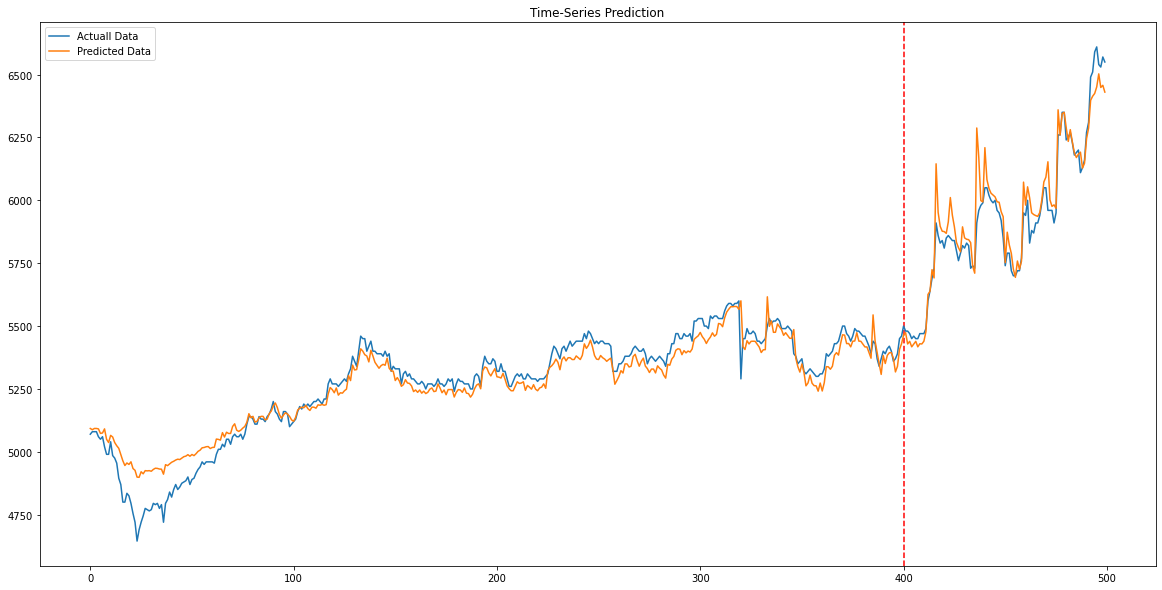

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

df= pd.read_csv("D:\송승규\Study\주식\내가하는거\주식데이터들\빅텍.csv", header=None,
                names=['날짜', '시가', '고가', '저가', '종가', '거래량'], encoding="CP949")

X = df.iloc[:, :3]
Y = df.iloc[:, 3:4]
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
Y_mm = mm.fit_transform(Y)

X_train = X_ss[:2900, :]
X_test = X_ss[2900:, :]

Y_train = Y_mm[:2900, :]
Y_test = Y_mm[2900:, :]

print("Training Shape", X_train.shape, Y_train.shape)
print("Testing Shape", X_test.shape, Y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

Y_train_tensors = Variable(torch.Tensor(Y_train))
Y_test_tensors = Variable(torch.Tensor(Y_test))

#reshape to rows, timestamps, features

X_train_tensors_finals = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_finals = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_finals.shape, Y_train_tensors.shape)
print("Testing Shpae", X_test_tensors_finals.shape, Y_test_tensors.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device print(torch.cuda.get_device_name(0))
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

    self.fc_1 = nn.Linear(hidden_size, 128)
    #self.fc = nn.Linear(128, num_classes)
    self.fc = nn.Linear(hidden_size, num_classes)

    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

    output, (hn, cn) = self.lstm(x, (h_0, c_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.fc(hn)
    return out

num_epochs = 1000
learning_rate = 0.001

input_size = 3
hidden_size = 2
num_layers = 1

num_classes = 1

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_finals.shape[1]).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr = learning_rate)

#train
for epoch in range(num_epochs):
  output = lstm1.forward(X_train_tensors_finals.to(device))
  optimizer.zero_grad()

  loss = loss_function(output, Y_train_tensors.to(device))

  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
df_X_ss = ss.transform(df.iloc[:, :3])
df_y_mm = mm.transform(df.iloc[:, 3:4])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(20,10)) #plotting
#plt.axvline(x=2800, c='r', linestyle='--') #size of the training set
plt.axvline(x=400, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 
